In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt
# https://www.jianshu.com/p/327cd9fda121

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

In [9]:
# 给生成器的
input_size = 100
# 随机生成噪声尺寸
batch_size = 200

In [10]:
dataset = datasets.MNIST('./data',download=True)
print(dataset.data.size())

torch.Size([60000, 28, 28])


In [11]:
data = dataset.data.reshape(-1, 1, 28, 28).float()
data = data / (255/2) - 1
# 数据控制到-1到1之间
print(dataset.data.size())

torch.Size([60000, 28, 28])


In [4]:
class DNet(nn.Module):
    # 判别器，识别图片，并返回正确率，越真实的图片正确率尽量接近1，否则接近0
    # input:(batch_size, 1, 28, 28)
    # output:(batch_size, 1)
    def __init__(self):
        super(DNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, 3, 2, padding=1)
        self.conv2 = nn.Conv2d(64, 128, 3, 2, padding=1)
        self.conv3 = nn.Conv2d(128, 256, 3, 2, padding=1)
        self.conv4 = nn.Conv2d(256, 512, 3, 1, padding=1)
        self.batch_norm1 = torch.nn.BatchNorm2d(128)
        self.batch_norm2 = torch.nn.BatchNorm2d(256)
        self.batch_norm3 = torch.nn.BatchNorm2d(512)
        self.leakyrelu = nn.LeakyReLU()
        self.linear = nn.Linear(8192, 1)

    def forward(self, x):
        # 28 14
        x = self.leakyrelu(self.conv1(x))
        # 7 128 feature
        x = self.leakyrelu(self.batch_norm1(self.conv2(x)))
        # 4
        x = self.leakyrelu(self.batch_norm2(self.conv3(x)))
        # 4
        x = self.leakyrelu(self.batch_norm3(self.conv4(x)))
        # 4*4*512=8192
        x = torch.flatten(x).reshape(-1, 8192)
        x = torch.sigmoid(self.linear(x))
        return x

In [5]:
# 在生成器模型中，传入一组随机的噪声，通过逆卷积等操作，生成一组格式为(1, 28, 28)的图片，模型代码如下：
class GNet(nn.Module):
    # 生成器，输入随机噪声，生成尽可能真实的图片
    # input:(batch_size, noise_size)
    # output:(batch_size, 1, 28, 28)
    def __init__(self, input_size):
        super(GNet, self).__init__()
        self.d = 3
        self.linear = nn.Linear(input_size, self.d*self.d*512)
        # in_channels, out_channels, kernel_size, stride=1, padding=0, 
        self.conv_tranpose1 = nn.ConvTranspose2d(512, 256, 5, 2, 1)
        self.conv_tranpose2 = nn.ConvTranspose2d(256, 128, 4, 2, 1)
        self.conv_tranpose3 = nn.ConvTranspose2d(128, 64, 4, 2, 1)
        self.conv_tranpose4 = nn.ConvTranspose2d(64, 1, 3, 1, 1)
        self.batch_norm1 = torch.nn.BatchNorm2d(512)
        self.batch_norm2 = torch.nn.BatchNorm2d(256)
        self.batch_norm3 = torch.nn.BatchNorm2d(128)
        self.batch_norm4 = torch.nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        # (200,100) -1 512 3 3 
        x = self.linear(x).reshape(-1, 512, self.d, self.d)
        x = self.relu(self.batch_norm1(x))
        #  256 (3-1)*2-1*2+5= 7 7
        x = self.conv_tranpose1(x)
        x = self.relu(self.batch_norm2(x))
        # 128 (7-1)*2+4-1*2=14
        x = self.conv_tranpose2(x)
        x = self.relu(self.batch_norm3(x))
        # 64 (14-1)*2+4-2=34+4-2=28
        x = self.conv_tranpose3(x)
        x = self.relu(self.batch_norm4(x))
        # 1 (28-1)*1+3-2=27+1=28
        # 1 28 28
        x = self.tanh(self.conv_tranpose4(x))
        # 像素值-1 1
        return x 

In [ ]:
dmodel = DNet().to(device)
gmodel = GNet(input_size).to(device)

In [ ]:
# 损失函数和优化器
loss_fun = nn.BCELoss()
# 使用BCE计算损失，如果用MSE的话很难收敛，而且计算也很慢
goptim = torch.optim.Adam(gmodel.parameters(), lr=0.0001)
doptim = torch.optim.Adam(dmodel.parameters(), lr=0.0001)

In [ ]:
# 训练数据
dmodel.train()
gmodel.train()
li_gloss = []
li_dloss = []

# 全1 batch_size==200
d_true = torch.ones(batch_size, 1).to(device)
# 全0
d_fake = torch.zeros(batch_size, 1).to(device)

for epoch in range(50):
    for batch in range(0, 60000, batch_size):
        batch_data = data[batch:batch+batch_size].to(device)
        # mnist集取出的真数据 input_size==100
        fake_data = torch.randn(batch_size, input_size).to(device)
        # 随机生成的假数据

        output_dtrue = dmodel(batch_data)
        # 先用判别器判别真数据
        loss_dtrue = loss_fun(output_dtrue, d_true)
        # 真数据的判别结果和1越近越好

        output_dfake = dmodel(gmodel(fake_data))
        # 再用判别器来判别通过假数据生成的图片
        loss_dfake = loss_fun(output_dfake, d_fake)
        # 对于判别器来说，假数据生成的图片的判别结果和0越近越好
        loss_d = loss_dtrue + loss_dfake

        # 两者的loss都是越小越好
        doptim.zero_grad()
        loss_d.backward()
        doptim.step()
        li_dloss.append(loss_d)

        # 在判别器有了判别能力以后开始训练生成器
        for i in range(3):
            # 因为生成器更难训练，所以每训练一次判别器就训练3次生成器
            output_gtrue = dmodel(gmodel(fake_data))
            # 判别通过假数据生成的图片
            loss_g = loss_fun(output_gtrue, d_true)
            # 对于生成器来说，生成的图片的判别结果越接近1越好，也就是越接近原图越好

            goptim.zero_grad()
            loss_g.backward()
            goptim.step()
            li_gloss.append(loss_g)

        print("epoch:{}, batch:{}, loss_d:{}, loss_g:{}".format(epoch, batch, loss_d, loss_g))

        torch.save(dmodel.state_dict(), "./model/gan_dmodel.mdl")
        torch.save(gmodel.state_dict(), "./model/gan_gmodel.mdl")
        
plt.plot(li_dloss)
plt.show()
plt.plot(li_gloss)
plt.show()

In [6]:
# 模型加载，当然得先有模型结构
# gmodel.load_state_dict(torch.load("./model/gan_gmodel.mdl"))
# dmodel.load_state_dict(torch.load("./model/gan_dmodel.mdl"))
gmodel = torch.load('./model/gmodel.pt')
dmodel = torch.load('./model/dmodel.pt')

G:\anaco\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.linear.Linear' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\anaco\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
G:\anaco\lib\site-packages\torch\serialization.py:453: SourceChangeWarning: source code of class 'torch.nn.modules.batchnorm.BatchNorm2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patche

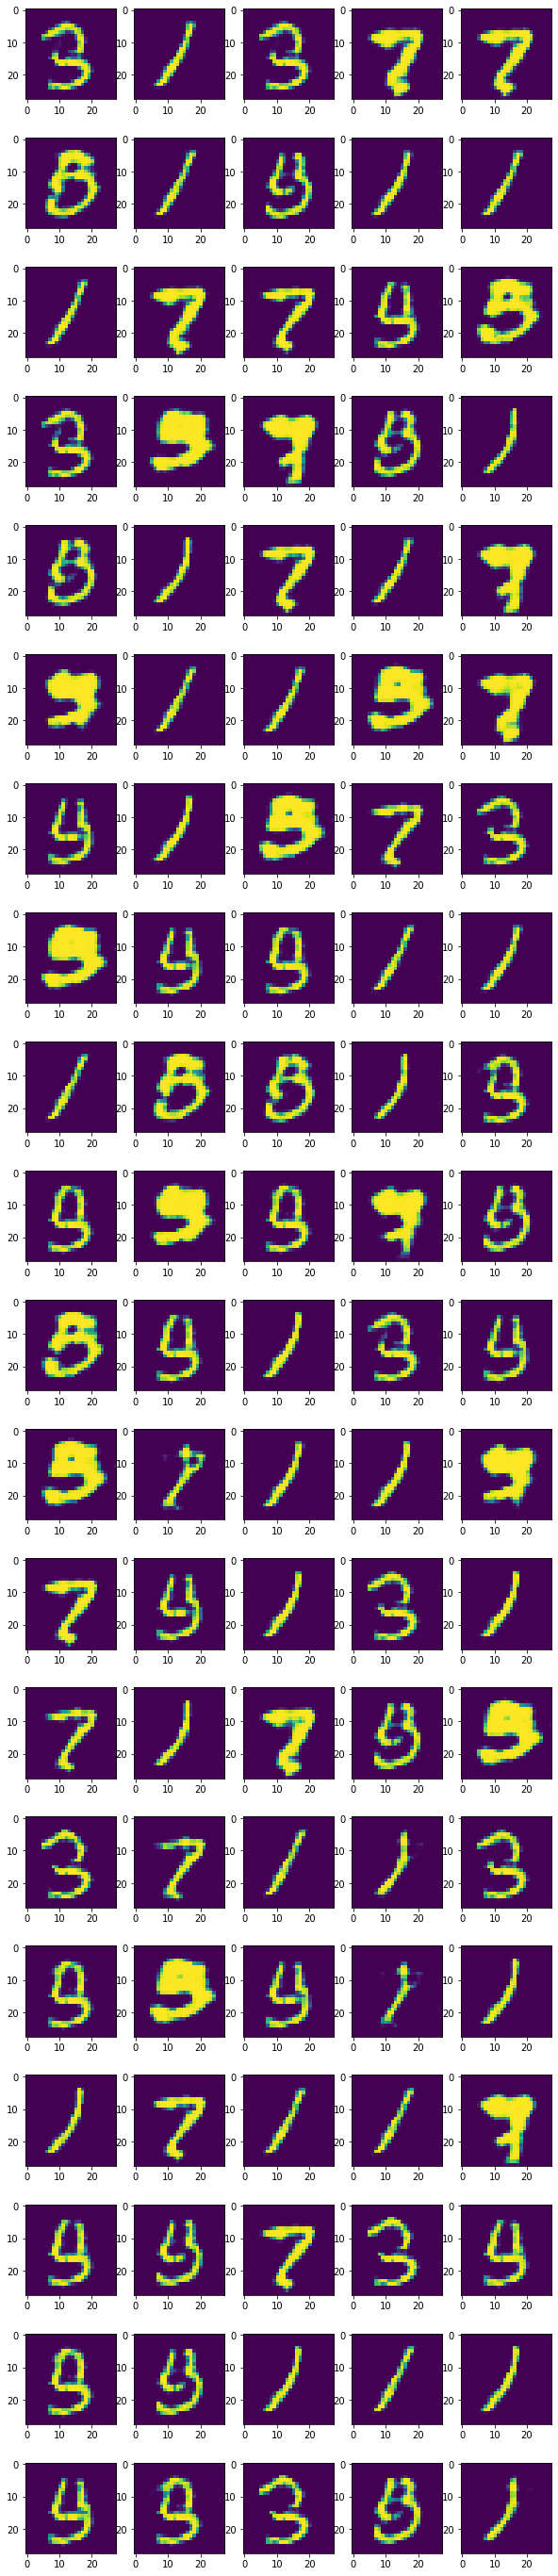

In [12]:
gmodel.eval()
data_test = torch.randn(100, 100)
result = gmodel(data_test.to(device))

plt.figure(figsize=(10, 50))
for i in range(len(result)):
    ax = plt.subplot(len(result) / 5, 5, i+1)
    plt.imshow((result[i].cpu().data.reshape(28, 28)+1)*255/2)
    # plt.gray()
plt.show()